In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Jun  8 16:05:13 2023

@author: oziel
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import datetime
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



In [2]:
#'/run/user/1000/gvfs/google-drive:host=gmail.com,user=ozieljr14/0AAGFG0sJpjdeUk9PVA/1BQG9CYJDzM17YcKGZ2Bv-3yo-ijSYBkO/1BZWZDK2-MdUUKwgiqxS8ZDuDxjsGlLzb/bd_pseudo_1.csv'
#/content/drive/MyDrive/Aviator/Data1/bd_pseudo_1.csv
path = '/content/drive/MyDrive/Aviator/Data1/bd_pseudo_1.csv'

data = pd.read_csv(path)

t = 0
print(len(data))
t0 = int(input("Maximo: "))
tamanho_data = len(data)

odd = []
horario = []
odd_ajustada = []

while t <= t0:
    if t < tamanho_data:
        value = data['odd'][t]
        if isinstance(value, float):
            odd.append(np.nan)  # or any other value to represent missing data
        else:
            aux = value.split('\n\n')
            a1 = aux[0].replace(')I', '')
            a2 = a1.replace(')', '')
            a3 = a2.replace('|', '1')
            a4 = a3.replace('?', '7')
            a5 = re.sub('[^0-9.]', '', a4)
            odd.append(float(a5))
        horario.append(data['hora_criacao'][t])

    t += 1

for name in odd:
    ajuste = float(name - 1.25)
    odd_ajustada.append(ajuste)

horas = []
minutos = []
segundos = []
for item in horario:
    dt = datetime.datetime.strptime(item, "%a %b %d %H:%M:%S %Y")
    horas.append(dt.hour)
    minutos.append(dt.minute)
    segundos.append(dt.second)


14017
Maximo: 14017


In [3]:
######################################################################################################################################
####################### LOCAL DATA ###################################################################################################
data1 = pd.DataFrame({'Odd_ajustada': odd_ajustada, 'hora': horas, 'minutos': minutos, 'segundos': segundos, 'horario': horario})

data2 = pd.DataFrame({'horario': horario, 'Odd_ajustada': odd})
######################################################################################################################################
######################################################################################################################################


In [20]:
dados_filtrados = data2[data2['Odd_ajustada'] < 5]

dados = data2

#dados = data2

dados['horario'] = pd.to_datetime(dados['horario'])
dados = dados.set_index('horario')


<ipython-input-20-3ebb510f480d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados['horario'] = pd.to_datetime(dados['horario'])


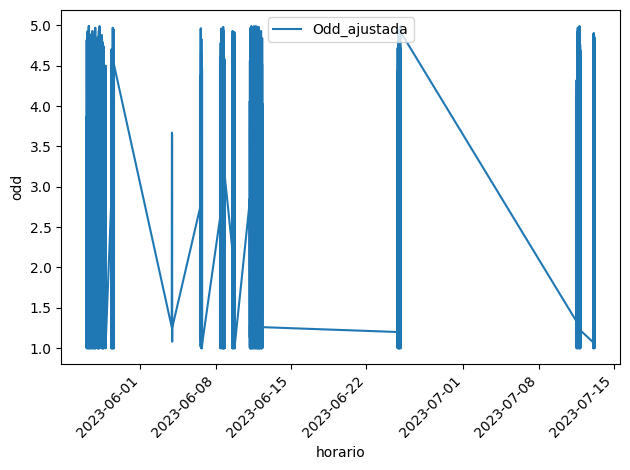

In [32]:
dados.plot()
plt.xticks(rotation=45)
plt.xlabel('horario')
plt.ylabel('odd')
plt.tight_layout()


In [34]:
#
t_treino = dados[dados.index<'2023-07-11 12:26:11'].index.values
t_teste = dados[dados.index>='2023-07-11 12:26:11'].index.values
X_treino = dados[dados.index<'2023-07-11 12:26:11'].values
X_teste = dados[dados.index>='2023-07-11 12:26:11'].values

modelo = SARIMAX(X_treino, order=(2,2,2), seasonal_order=(0,1,1,12))
resultado = modelo.fit()

print('Coefficients: %s', resultado.params)
print(resultado.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Coefficients: %s [ 0.00421407  0.02404225 -1.99135042  0.99155117 -0.99994344  0.96863123]
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                10134
Model:             SARIMAX(2, 2, 2)x(0, 1, [1], 12)   Log Likelihood              -14225.983
Date:                              Mon, 17 Jul 2023   AIC                          28463.966
Time:                                      15:51:11   BIC                          28507.300
Sample:                                           0   HQIC                         28478.626
                                            - 10134                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1  

In [35]:

X_pred = resultado.predict(start=len(X_treino), end=len(X_treino)+len(X_teste)-1)



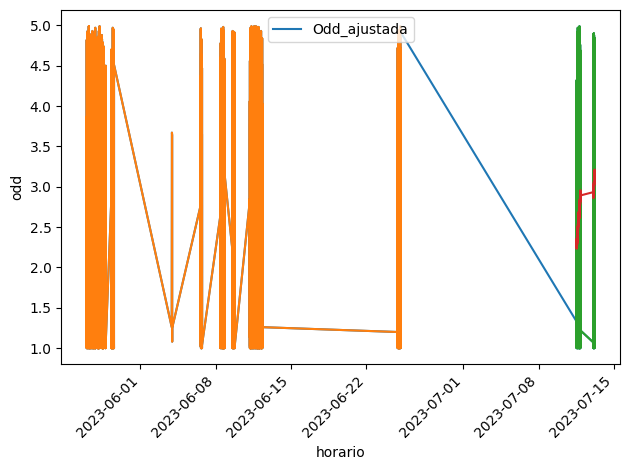

In [38]:
dados.plot()
plt.xticks(rotation=45)
plt.xlabel('horario')
plt.ylabel('odd')
plt.tight_layout()

plt.plot(t_treino,X_treino)
plt.plot(t_teste,X_teste)
plt.plot(t_teste,X_pred)



In [39]:
MSE = mean_squared_error(X_teste,X_pred)
RMSE = np.sqrt(MSE)
print("RMSE = {:0.2f}".format(RMSE))


RMSE = 1.25


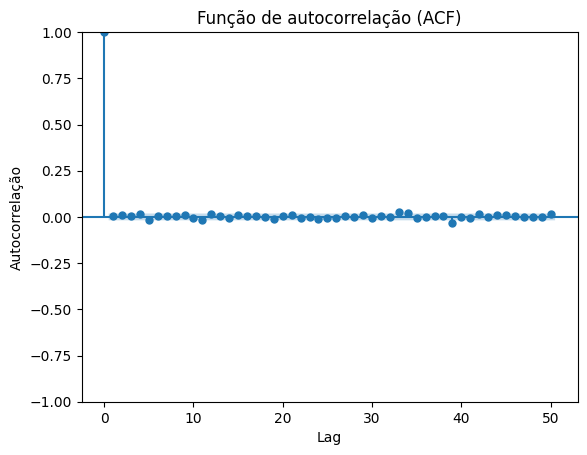

In [40]:

#Plo da ACF
plot_acf(dados['Odd_ajustada'],lags = 50)
plt.xlabel('Lag')
plt.ylabel('Autocorrelação')
plt.title('Função de autocorrelação (ACF)')
plt.show()



/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


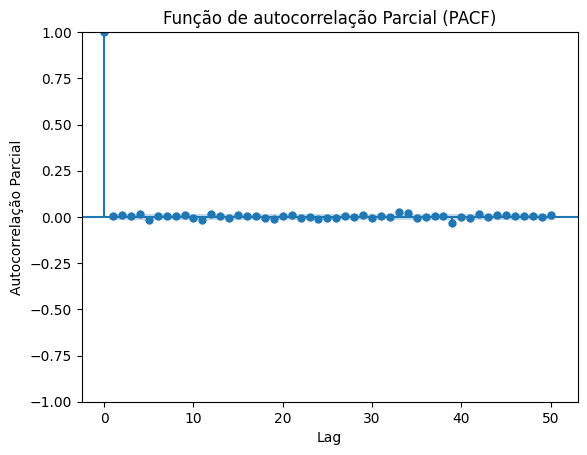

In [41]:

#Plot da PACF
plot_pacf(dados['Odd_ajustada'],lags = 50)
plt.xlabel('Lag')
plt.ylabel('Autocorrelação Parcial')
plt.title('Função de autocorrelação Parcial (PACF)')
plt.show()



In [42]:
numero = 50
previsao = resultado.get_prediction(start=len(dados), end=len(dados)+numero)

valores_previstos = np.array(previsao.predicted_mean)


print('A partir de: ', dados['Odd_ajustada'][-1])
print(previsao)
print(valores_previstos)


A partir de:  2.61
[3.14661515 3.18836264 3.15207393 3.15601251 3.11301611 3.12691414
 3.19669813 3.16065474 3.18249964 3.22175359 3.13859248 3.16314537
 3.1560393  3.19778669 3.16149788 3.16543635 3.12243986 3.13633778
 3.20612167 3.17007818 3.19192299 3.23117684 3.14801563 3.17256841
 3.16546225 3.20720954 3.17092062 3.174859   3.13186241 3.14576023
 3.21554402 3.17950043 3.20134513 3.24059889 3.15743757 3.18199026
 3.17488399 3.21663118 3.18034216 3.18428044 3.14128375 3.15518147
 3.22496516 3.18892147 3.21076608 3.25001973 3.16685831 3.1914109
 3.18430453 3.22605162 3.18976251]
